# InternVL3.5-8B: 2-Turn Balance-Description Bank Statement Extraction

**Protocol**: Two independent single-turn prompts using Balance-Description approach

**Key Insight**: Anchoring extraction to the Balance column works for BOTH date-per-row AND date-grouped formats!

**Model**: InternVL3.5-8B (non-quantized, bfloat16) optimized for H200 GPU

---

## Complete Workflow

```
Turn 0: Image + Prompt → Headers (fresh context)
        ↓ (Python pattern matching)
Turn 1: Image + Balance-Description Prompt → Hierarchical balance list (fresh context)
        ↓ (Python parsing + filtering)
Schema Fields: TRANSACTION_DATES, LINE_ITEM_DESCRIPTIONS, TRANSACTION_AMOUNTS_PAID
```

### Why Balance-Description Works:
- **Balance anchoring**: Every transaction has a balance - use it as the anchor point
- **Format agnostic**: Works for both date-per-row and date-grouped formats
- **No date format classification needed**: Eliminates Turn 0.5 entirely
- **Hierarchical output**: Balance → Date, Description, Debit/Credit amounts

### Pipeline Stages:
1. **Turn 0 (LLM)**: Identify column headers from image
2. **Pattern Matching (Python)**: Map headers to concepts (Date, Description, Debit, Credit, Balance)
3. **Turn 1 (LLM)**: Extract using balance-description prompt (format-agnostic)
4. **Python Parsing**: Parse hierarchical output → Filter for debits → Extract schema fields

### Critical Features:
- ❌ **No Turn 0.5** - No date format classification needed!
- ✅ **Balance anchoring** - Works for all statement formats
- ✅ **Python filtering** - Reliable debit/credit separation
- ✅ **Hierarchical output** - Clear structure for parsing

### Model: InternVL3.5-8B
- **Non-quantized** for H200 GPU with 80GB HBM3
- **bfloat16** precision for optimal performance
- **Flash Attention** enabled for efficiency
- Higher capacity than 2B variant
- Simple API with `model.chat()` method

In [1]:
# Cell 1: Imports and Configuration
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Add parent directory to path AND change working directory for config file resolution
import sys
from pathlib import Path

# Get project root (parent of bank_statement/)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Change working directory to project root so config/field_definitions.yaml is found
os.chdir(project_root)
print(f"📁 Working directory: {os.getcwd()}")

import random
import math
import re

import numpy as np
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

# IPython display for rendering markdown
from IPython.display import display, Markdown, HTML

# ============================================================================
# CONFIGURATION
# ============================================================================
CONFIG = {
    # Model path - update for your environment
    "MODEL_PATH": "/home/jovyan/nfs_share/models/InternVL3_5-8B",

    
    # Generation settings
    "MAX_NEW_TOKENS": 3064,
    
    # Image processing - H200 optimized
    "MAX_TILES": 12,  # H200 optimized (use 14 for V100, 18 for A10G)
    
    # H200 precision settings
    "TORCH_DTYPE": "bfloat16",
    "USE_FLASH_ATTN": True,  # Supported on Ampere and newer
}

print(f"✅ Configuration loaded:")
print(f"   Model: {CONFIG['MODEL_PATH']}")
print(f"   Max tiles: {CONFIG['MAX_TILES']}")
print(f"   Flash Attention: {CONFIG['USE_FLASH_ATTN']}")

📁 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Configuration loaded:
   Model: /home/jovyan/nfs_share/models/InternVL3_5-8B
   Max tiles: 12
   Flash Attention: True


# Set Random Seed for Reproducibility

In [2]:
# Cell 3: Set random seed

from common.reproducibility import set_seed, configure_deterministic_mode
set_seed(42)
configure_deterministic_mode(True) 

✅ Random seed set to 42 for reproducibility
✅ PyTorch deterministic mode enabled
⚠️  Note: May reduce performance


# Load the model

In [3]:
# Cell 5: Load InternVL3.5-8B model (non-quantized for H200)

print("🔧 Loading InternVL3.5-8B (non-quantized, bfloat16) for H200 GPU...")

# Load model with bfloat16 and flash attention for H200
model = AutoModel.from_pretrained(
    CONFIG['MODEL_PATH'],
    dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    use_flash_attn=CONFIG['USE_FLASH_ATTN'],
).eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    CONFIG['MODEL_PATH'],
    trust_remote_code=True,
    use_fast=False
)

# Set generation config on model
model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']

# Fix pad_token_id to suppress warnings
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✅ InternVL3.5-8B model loaded successfully!")
print(f"✅ Model distributed across devices: {model.hf_device_map}")
print(f"📊 Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Precision: bfloat16 with flash attention")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']}")

🔧 Loading InternVL3.5-8B (non-quantized, bfloat16) for H200 GPU...
FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ InternVL3.5-8B model loaded successfully!
✅ Model distributed across devices: {'': 0}
📊 Parameters: 8,528,318,464
📊 Precision: bfloat16 with flash attention
🔲 Max Tiles: 12


# Load the image

In [4]:
# Cell 7: Load bank statement image
# Update this path to your test image
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_003.png"
imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_009.png"
# imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_chrono.png")
# imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_multiline.png")
imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_reverse_chrono.png")


print("📁 Loading image...")
image = Image.open(imageName)

# CRITICAL: Store as list for multi-turn compatibility
images = [image]

print(f"✅ Image loaded: {image.size}")
print(f"✅ Images list created with {len(images)} image(s)")

📁 Loading image...
✅ Image loaded: (1200, 1310)
✅ Images list created with 1 image(s)


🖼️  Bank statement image:


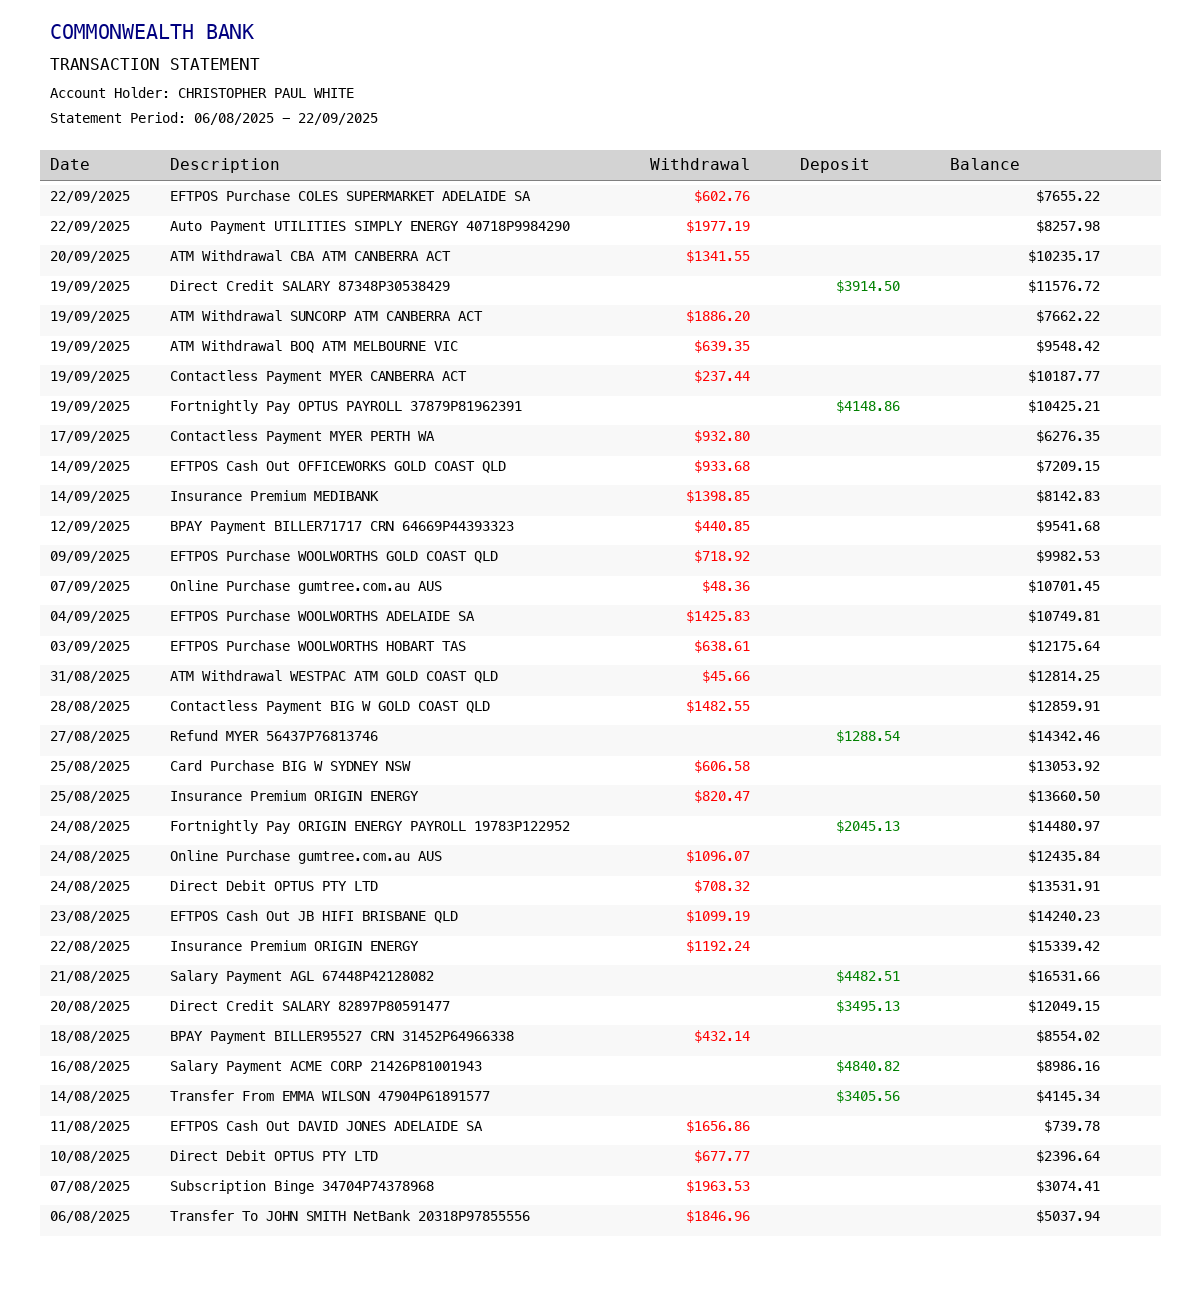

In [5]:
# Display the loaded image for visual verification
print("🖼️  Bank statement image:")
display(image)

In [6]:
# Cell 9: Image preprocessing for InternVL3.5 (Official implementation)

# Official InternVL3 image preprocessing (from docs)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.229)

def build_transform(input_size):
    """Build image transformation pipeline with ImageNet normalization."""
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    """Find the closest aspect ratio from target ratios based on image dimensions."""
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=None, image_size=448, use_thumbnail=False):
    """
    Dynamically preprocess image by splitting into tiles based on aspect ratio.
    
    Args:
        image: PIL Image
        min_num: Minimum number of tiles
        max_num: Maximum number of tiles (from CONFIG['MAX_TILES'])
        image_size: Size of each tile (448 for InternVL3)
        use_thumbnail: Whether to include thumbnail image
    
    Returns:
        List of PIL Image tiles
    """
    # Use CONFIG if max_num not specified
    if max_num is None:
        max_num = CONFIG['MAX_TILES']
    
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # Generate target aspect ratios
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # Find best aspect ratio
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # Calculate target dimensions
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # Resize and split into tiles
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    
    assert len(processed_images) == blocks
    
    # Add thumbnail if requested
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    
    return processed_images

def load_image(image_file, input_size=448, max_num=None):
    """
    Load and preprocess image for InternVL3.5.
    
    Args:
        image_file: Path to image or PIL Image object
        input_size: Size of each tile (448 for InternVL3)
        max_num: Max number of tiles (uses CONFIG['MAX_TILES'] if None)
    
    Returns:
        pixel_values: Preprocessed tensor ready for model.chat()
    """
    # Use CONFIG if max_num not specified
    if max_num is None:
        max_num = CONFIG['MAX_TILES']
    
    # Handle both path string and PIL Image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    
    # Build transform and preprocess
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(img) for img in images]
    pixel_values = torch.stack(pixel_values)
    
    return pixel_values

print("✅ InternVL3.5 image preprocessing functions defined")
print(f"🔲 Using max_num={CONFIG['MAX_TILES']} tiles (from CONFIG)")
print(f"💡 Image preprocessing: ImageNet normalization + dynamic tiling")

✅ InternVL3.5 image preprocessing functions defined
🔲 Using max_num=12 tiles (from CONFIG)
💡 Image preprocessing: ImageNet normalization + dynamic tiling


# Bank Statement Extraction Protocol (2-Turn Balance-Description)
- Turn 0: Identify actual table headers
- Turn 1: Extract using balance-description prompt (format-agnostic)
- Python: Parse hierarchical output, filter, and extract schema fields

In [7]:
# Cell 11: Turn 0 - Identify table headers (prompt)
# TURN 0: Identify Table Headers
# First, identify the actual column headers used in this specific bank statement

prompt = """
Look at the transaction table in this bank statement image.

IMPORTANT STRUCTURAL NOTE:
Some bank statements show dates as section headings with multiple transactions underneath.
If you see this structure, remember that each transaction needs its explicit date in the final output.

What are the exact column header names used in the transaction table?

List each column header exactly as it appears, in order from left to right.
Do not interpret or rename them - use the EXACT text from the image.
"""

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with InternVL3.5-8B...")

💬 TURN 0: Identifying actual table headers
🤖 Generating response with InternVL3.5-8B...


In [8]:
# Cell 12: Turn 0 - Execute and parse headers (InternVL3.5-8B version)

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with InternVL3.5-8B (bfloat16)...")

# Load and preprocess image for InternVL3.5 (uses CONFIG['MAX_TILES'])
pixel_values = load_image(imageName, input_size=448)

# Move to correct device and dtype for InternVL3.5-8B
# CRITICAL: Use bfloat16 for non-quantized H200 models
vision_device = 'cuda:0'  # Vision model is on GPU 0
model_dtype = torch.bfloat16
pixel_values = pixel_values.to(dtype=model_dtype, device=vision_device)

# Generate response using chat() method
cleanedOutput = model.chat(
    tokenizer=tokenizer,
    pixel_values=pixel_values,
    question=prompt,
    generation_config={
        "max_new_tokens": CONFIG['MAX_NEW_TOKENS'],
        "do_sample": False  # Greedy decoding for consistency
    }
)

# Clean InternVL3 artifacts:
# 1. Remove image markdown placeholder (![...])
# 2. Remove markdown code fences (```markdown and ```)
lines = cleanedOutput.split("\n")
cleaned_lines = []
for line in lines:
    stripped = line.strip()
    # Skip image markdown, code fences, and empty fence markers
    if stripped.startswith("!["):
        continue
    if stripped in ["```markdown", "```", "```md"]:
        continue
    cleaned_lines.append(line)

cleanedOutput = "\n".join(cleaned_lines)

print("✅ Response generated successfully!")
print("\n" + "=" * 60)
print("TURN 0 - IDENTIFIED TABLE HEADERS:")
print("=" * 60)
print(cleanedOutput)
print("=" * 60)

# CRITICAL: Parse the identified headers for use in subsequent turns
# Extract column names from the response
header_lines = [line.strip() for line in cleanedOutput.split('\n') if line.strip()]
identified_headers = []

# Look for numbered list or bullet points
for line in header_lines:
    # Remove common list markers
    cleaned = line.lstrip('0123456789.-•* ').strip()
    
    # Strip markdown bold formatting
    cleaned = cleaned.replace('**', '').replace('__', '')
    
    # Skip section headers (lines ending with colon)
    if cleaned.endswith(':'):
        continue
    
    # Skip long sentences (likely explanatory text, not headers)
    if len(cleaned) > 40:
        continue
        
    if cleaned and len(cleaned) > 2:  # Ignore very short strings
        identified_headers.append(cleaned)

print(f"\n📋 Parsed {len(identified_headers)} column headers:")
for i, header in enumerate(identified_headers, 1):
    print(f"  {i}. '{header}'")

# Store headers for use in subsequent turns
table_headers = identified_headers

# Save the table headers
output_path = Path("ivl3_5_8b_2turn_table_headers.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput)

print(f"\n✅ Table headers saved to: {output_path}")
print("💡 These LITERAL header names will be used in Turn 1 balance-description prompt")

💬 TURN 0: Identifying actual table headers
🤖 Generating response with InternVL3.5-8B (bfloat16)...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


✅ Response generated successfully!

TURN 0 - IDENTIFIED TABLE HEADERS:
The exact column header names used in the transaction table are:

1. Date
2. Description
3. Withdrawal
4. Deposit
5. Balance

📋 Parsed 5 column headers:
  1. 'Date'
  2. 'Description'
  3. 'Withdrawal'
  4. 'Deposit'
  5. 'Balance'

✅ Table headers saved to: ivl3_5_8b_2turn_table_headers.txt
💡 These LITERAL header names will be used in Turn 1 balance-description prompt


## Pattern Matching: Map Generic Concepts to Actual Headers

Different bank statements use different column names. Use pattern matching to identify:
- Which header represents **Date**
- Which header represents **Description/Details**  
- Which header represents **Debit/Withdrawal**
- Which header represents **Credit/Deposit**
- Which header represents **Balance**

In [9]:
# Cell 14: Pattern Matching - Map headers to generic columns
# Pattern Matching: Map extracted headers to generic concepts
# This handles variety in bank statement column naming conventions

# Pattern keywords for each concept (in priority order)
DATE_PATTERNS = ['date', 'day', 'transaction date', 'trans date']
DESCRIPTION_PATTERNS = [
    'description', 'details', 'transaction details', 'trans details',
    'particulars', 'narrative', 'transaction', 'trans'
]
DEBIT_PATTERNS = ['debit', 'withdrawal', 'withdrawals', 'paid', 'paid out', 'spent', 'dr']
CREDIT_PATTERNS = ['credit', 'deposit', 'deposits', 'received', 'cr']
BALANCE_PATTERNS = ['balance', 'bal', 'running balance']

# NEW: Pattern for single-column transaction formats (e.g., "Amount" instead of separate Debit/Credit)
AMOUNT_PATTERNS = ['amount', 'amt', 'value', 'total']

def match_header(headers, patterns, fallback=None):
    """Match a header using pattern keywords.
    
    Matching strategy:
    1. Exact match (case-insensitive)
    2. Substring match (only for patterns with length > 2 to avoid false positives)
    """
    headers_lower = [h.lower() for h in headers]
    
    # Try exact match first
    for pattern in patterns:
        for i, header_lower in enumerate(headers_lower):
            if pattern == header_lower:
                return headers[i]
    
    # Try substring match (only for patterns longer than 2 chars)
    for pattern in patterns:
        if len(pattern) > 2:  # Avoid false positives like 'cr' matching 'description'
            for i, header_lower in enumerate(headers_lower):
                if pattern in header_lower:
                    return headers[i]
    
    return fallback

# Perform pattern matching on extracted headers
date_col = match_header(table_headers, DATE_PATTERNS, fallback=table_headers[0] if table_headers else 'Date')
desc_col = match_header(table_headers, DESCRIPTION_PATTERNS, fallback=table_headers[1] if len(table_headers) > 1 else 'Description')

# NEW: First try to match a generic "Amount" column (for 4-column formats)
amount_col = match_header(table_headers, AMOUNT_PATTERNS, fallback=None)

# Use amount_col as fallback if no separate debit/credit columns exist
# This handles formats like: Date | Description | Amount | Balance
debit_col = match_header(table_headers, DEBIT_PATTERNS, fallback=amount_col if amount_col else 'Debit')
credit_col = match_header(table_headers, CREDIT_PATTERNS, fallback=amount_col if amount_col else 'Credit')
balance_col = match_header(table_headers, BALANCE_PATTERNS, fallback='Balance')

print("=" * 60)
print("PATTERN MATCHING RESULTS:")
print("=" * 60)
print(f"📋 Extracted Headers: {table_headers}")
print(f"\n🔍 Mapped Columns:")
print(f"  Date        → '{date_col}'")
print(f"  Description → '{desc_col}'")
print(f"  Debit       → '{debit_col}'")
print(f"  Credit      → '{credit_col}'")
print(f"  Balance     → '{balance_col}'")
if amount_col:
    print(f"\n💡 Single-column format detected: '{amount_col}' used for both debit and credit")
print("=" * 60)
print("\n✅ These literal column names will be used in Turn 1 balance-description prompt")
print("💡 Adjust patterns above if matching fails for your bank statement format")

PATTERN MATCHING RESULTS:
📋 Extracted Headers: ['Date', 'Description', 'Withdrawal', 'Deposit', 'Balance']

🔍 Mapped Columns:
  Date        → 'Date'
  Description → 'Description'
  Debit       → 'Withdrawal'
  Credit      → 'Deposit'
  Balance     → 'Balance'

✅ These literal column names will be used in Turn 1 balance-description prompt
💡 Adjust patterns above if matching fails for your bank statement format


## Turn 1: Balance-Description Extraction Prompt

**Key Insight**: Instead of extracting a markdown table, we ask the model to list balances with their associated transaction details. This approach:

1. **Anchors to Balance column** - Every transaction has a balance
2. **Works for all formats** - Date-per-row AND date-grouped formats
3. **Hierarchical output** - Easy to parse programmatically
4. **No date format classification** - Eliminates Turn 0.5 entirely

In [10]:
# Cell 16: Generate Balance-Description Extraction Prompt

# Build the balance-description extraction prompt using LITERAL column names from Turn 0
extraction_prompt = f"""List all the balances in the {balance_col} column, including:
- Date from the Date Header of the balance
- {desc_col}
- {debit_col} Amount or "NOT_FOUND"
- {credit_col} Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - {desc_col}: [description text]
   - {debit_col}: [amount or NOT_FOUND]
   - {credit_col}: [amount or NOT_FOUND]
   - {balance_col}: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. EVERY balance entry has a date, either on the same row, or above
3. Include the FULL description text, not abbreviated
4. If amount is in {debit_col} column, put it there and use NOT_FOUND for {credit_col}
5. If amount is in {credit_col} column, put it there and use NOT_FOUND for {debit_col}
6. Do NOT skip any transactions
"""

print("\n" + "=" * 60)
print("Turn 1 Balance-Description Extraction Prompt:")
print("=" * 60)
print(f"\n{extraction_prompt}")
print("=" * 60 + "\n")


Turn 1 Balance-Description Extraction Prompt:

List all the balances in the Balance column, including:
- Date from the Date Header of the balance
- Description
- Withdrawal Amount or "NOT_FOUND"
- Deposit Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - Description: [description text]
   - Withdrawal: [amount or NOT_FOUND]
   - Deposit: [amount or NOT_FOUND]
   - Balance: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. EVERY balance entry has a date, either on the same row, or above
3. Include the FULL description text, not abbreviated
4. If amount is in Withdrawal column, put it there and use NOT_FOUND for Deposit
5. If amount is in Deposit column, put it there and use NOT_FOUND for Withdrawal
6. Do NOT skip any transactions




In [11]:
# Cell 17: Turn 1 - Execute Balance-Description Extraction (InternVL3.5-8B, INDEPENDENT fresh context)

print("🤖 Generating response with InternVL3.5-8B (bfloat16)...")

# CRITICAL: Reload image for fresh context (independent turn, not continuing conversation)
# Uses CONFIG['MAX_TILES'] automatically
pixel_values = load_image(imageName, input_size=448)

# Move to correct device and dtype
# CRITICAL: Use bfloat16 for non-quantized H200 models
pixel_values = pixel_values.to(dtype=torch.bfloat16, device='cuda:0')

# Generate response using chat() method with balance-description prompt
cleanedOutput2 = model.chat(
    tokenizer=tokenizer,
    pixel_values=pixel_values,
    question=extraction_prompt,
    generation_config={
        "max_new_tokens": CONFIG['MAX_NEW_TOKENS'],
        "do_sample": False
    }
)

# Clean InternVL3 artifacts:
# 1. Remove image markdown placeholder (![...])
# 2. Remove markdown code fences (```markdown and ```)
lines = cleanedOutput2.split("\n")
cleaned_lines = []
for line in lines:
    stripped = line.strip()
    # Skip image markdown, code fences, and empty fence markers
    if stripped.startswith("!["):
        continue
    if stripped in ["```markdown", "```", "```md"]:
        continue
    cleaned_lines.append(line)

cleanedOutput2 = "\n".join(cleaned_lines)

print("\n✅ Turn 1 balance-description extraction complete!")

print("\n" + "=" * 60)
print("TURN 1 - BALANCE-DESCRIPTION OUTPUT:")
print("=" * 60)
print(cleanedOutput2)
print("=" * 60)

# Save the balance-description output
output_path = Path("ivl3_5_8b_2turn_balance_description.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput2)

print(f"\n✅ Balance-description output saved to: {output_path}")

🤖 Generating response with InternVL3.5-8B (bfloat16)...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



✅ Turn 1 balance-description extraction complete!

TURN 1 - BALANCE-DESCRIPTION OUTPUT:
1. **22/09/2025**
   - Description: EFTPOS Purchase COLES SUPERMARKET ADELAIDE SA
   - Withdrawal: $602.76
   - Deposit: NOT_FOUND
   - Balance: $7655.22

2. **22/09/2025**
   - Description: Auto Payment UTILITIES SIMPLY ENERGY 40718P9984290
   - Withdrawal: $1977.19
   - Deposit: NOT_FOUND
   - Balance: $8257.98

3. **20/09/2025**
   - Description: ATM Withdrawal CBA ATM CANBERRA ACT
   - Withdrawal: $1341.55
   - Deposit: NOT_FOUND
   - Balance: $10235.17

4. **19/09/2025**
   - Description: Direct Credit SALARY 87348P30538429
   - Withdrawal: NOT_FOUND
   - Deposit: $3914.50
   - Balance: $11576.72

5. **19/09/2025**
   - Description: ATM Withdrawal SUNCORP ATM CANBERRA ACT
   - Withdrawal: $1886.20
   - Deposit: NOT_FOUND
   - Balance: $7662.22

6. **19/09/2025**
   - Description: ATM Withdrawal BQ ATM MELBOURNE VIC
   - Withdrawal: $639.35
   - Deposit: NOT_FOUND
   - Balance: $9548.42

7. **1

## Python Parsing: Parse Balance-Description Output

Parse the hierarchical balance-description output into structured rows, filter for debit transactions, and extract schema fields.

In [12]:
# Cell 19: Parse Balance-Description Response + Validation + Extraction
# Parses Turn 1 output, validates debit/credit alignment, filters, and extracts schema fields

import re
from dateutil import parser as date_parser


# ============================================================================
# PARSING FUNCTION: Balance-Description Response Parser
# ============================================================================
def parse_balance_description_response(response_text, date_col, desc_col, debit_col, credit_col, balance_col):
    """Parse the hierarchical balance-description response into transaction rows.

    Handles multiple output formats:
    - InternVL3: "1. **Date:** 03/05/2025" with "**Field:** value"
    - Llama: "**03/05/2025**" with "* Field: value"
    - Standard: "1. **date**" with "- Field: value"
    """
    rows = []
    current_date = None
    current_transaction = {}

    lines = response_text.strip().split("\n")

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # ============================================================
        # DATE DETECTION PATTERNS
        # ============================================================
        date_found = None

        # Pattern 1: InternVL3 format "1. **Date:** 03/05/2025" or "**Date:** 03/05/2025"
        date_field_match = re.match(r"^\d*\.?\s*\*?\*?Date:?\*?\*?\s*(.+)$", line, re.IGNORECASE)
        if date_field_match:
            date_found = date_field_match.group(1).strip().strip('*').strip()

        # Pattern 2: Bold date header "**03/05/2025**" (Llama style)
        if not date_found:
            bold_date_match = re.match(r"^\*\*(\d{1,2}/\d{1,2}/\d{4})\*\*$", line)
            if bold_date_match:
                date_found = bold_date_match.group(1)

        # Pattern 3: Numbered bold date "1. **Thu 04 Sep 2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?([A-Za-z]{3}\s+\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        # Pattern 4: Numbered date without day "1. **04 Sep 2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        # Pattern 5: Numbered DD/MM/YYYY "1. **03/05/2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}/\d{1,2}/\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        if date_found:
            # Save previous transaction if exists
            if current_transaction and current_date:
                current_transaction[date_col] = current_date
                rows.append(current_transaction)
                current_transaction = {}
            current_date = date_found
            continue

        # ============================================================
        # FIELD DETECTION PATTERNS
        # ============================================================
        field_name = None
        field_value = None

        # Pattern 1: "**Description:** value" (InternVL3 style)
        bold_field_match = re.match(r"^\s*\*\*([^*:]+)(?:\s*Amount)?:?\*\*\s*(.+)$", line, re.IGNORECASE)
        if bold_field_match:
            field_name = bold_field_match.group(1).strip().lower()
            field_value = bold_field_match.group(2).strip()

        # Pattern 2: "* Description: value" (Llama style with asterisk bullet)
        if not field_name:
            asterisk_field_match = re.match(r"^\s*\*\s*([^:]+):\s*(.+)$", line)
            if asterisk_field_match:
                field_name = asterisk_field_match.group(1).strip().lower()
                field_value = asterisk_field_match.group(2).strip()

        # Pattern 3: "- Description: value" (standard style)
        if not field_name:
            dash_field_match = re.match(r"^\s*-\s*([^:]+):\s*(.+)$", line)
            if dash_field_match:
                field_name = dash_field_match.group(1).strip().lower()
                field_value = dash_field_match.group(2).strip()

        if field_name and field_value:
            # Normalize field names (remove "amount" suffix, handle variants)
            field_name = field_name.replace(" amount", "").strip()

            # Map to appropriate column
            if field_name in ["description", "transaction", "details", "particulars", desc_col.lower()]:
                # If we already have a description, this is a new transaction under same date
                if desc_col in current_transaction and current_transaction[desc_col]:
                    if current_date:
                        current_transaction[date_col] = current_date
                    rows.append(current_transaction)
                    current_transaction = {}
                current_transaction[desc_col] = field_value

            elif field_name in ["debit", "withdrawal", "withdrawwal", "dr", debit_col.lower()]:
                current_transaction[debit_col] = field_value

            elif field_name in ["credit", "deposit", "cr", credit_col.lower()]:
                current_transaction[credit_col] = field_value

            elif field_name == "balance":
                current_transaction[balance_col] = field_value

            elif field_name == "amount":
                # Generic amount - put in debit by default
                if debit_col not in current_transaction:
                    current_transaction[debit_col] = field_value

    # Don't forget the last transaction
    if current_transaction and current_date:
        current_transaction[date_col] = current_date
        rows.append(current_transaction)

    return rows


def parse_markdown_table(markdown_text):
    """Fallback: Parse markdown table."""
    lines = [line.strip() for line in markdown_text.strip().split('\n') if line.strip()]
    
    header_idx = None
    for i, line in enumerate(lines):
        if '|' in line:
            cleaned = line.replace('|', '').replace('-', '').replace(' ', '')
            if cleaned:
                header_idx = i
                break
    
    if header_idx is None:
        return []
    
    header_line = lines[header_idx]
    header_parts = [h.strip() for h in header_line.split('|')]
    if header_parts and header_parts[0] == '':
        header_parts = header_parts[1:]
    if header_parts and header_parts[-1] == '':
        header_parts = header_parts[:-1]
    headers = [h for h in header_parts if h]
    
    rows = []
    for line in lines[header_idx + 1:]:
        if '|' not in line:
            continue
        cleaned = line.replace('|', '').replace('-', '').replace(' ', '').replace(':', '')
        if not cleaned:
            continue
        value_parts = [v.strip() for v in line.split('|')]
        if value_parts and value_parts[0] == '':
            value_parts = value_parts[1:]
        if value_parts and value_parts[-1] == '':
            value_parts = value_parts[:-1]
        if len(value_parts) == len(headers):
            rows.append(dict(zip(headers, value_parts)))
    
    return rows


# ============================================================================
# BALANCE VALIDATION FUNCTIONS
# ============================================================================
def sort_rows_by_date(rows, date_col):
    """Sort rows by date in chronological order (oldest first)."""
    if not rows or date_col not in rows[0]:
        print(f"⚠️  Date column '{date_col}' not found - cannot sort")
        return rows, list(range(len(rows))), False
    
    def parse_date(date_str):
        if not date_str or not date_str.strip():
            return None
        try:
            return date_parser.parse(date_str.strip(), dayfirst=True)
        except (ValueError, TypeError):
            return None
    
    dated_rows = []
    for i, row in enumerate(rows):
        parsed = parse_date(row.get(date_col, ""))
        dated_rows.append((parsed, i, row))
    
    failed_parses = sum(1 for d, _, _ in dated_rows if d is None)
    if failed_parses > len(rows) * 0.5:
        print(f"⚠️  Too many date parse failures ({failed_parses}/{len(rows)}) - cannot sort reliably")
        return rows, list(range(len(rows))), False
    
    sorted_dated = sorted(dated_rows, key=lambda x: (x[0] is None, x[0]))
    sorted_rows = [row for _, _, row in sorted_dated]
    original_indices = [orig_idx for _, orig_idx, _ in sorted_dated]
    was_reordered = original_indices != list(range(len(rows)))
    
    return sorted_rows, original_indices, was_reordered


def detect_document_order(rows, balance_col):
    """Detect if document is in chronological or reverse chronological order."""
    def parse_amount(value):
        if not value or value.strip() == "":
            return 0.0
        cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    
    if len(rows) < 3:
        return "chronological"
    
    increases = 0
    decreases = 0
    
    for i in range(1, min(len(rows), 10)):
        prev_balance = parse_amount(rows[i-1].get(balance_col, "0"))
        curr_balance = parse_amount(rows[i].get(balance_col, "0"))
        
        if curr_balance > prev_balance + 0.01:
            increases += 1
        elif curr_balance < prev_balance - 0.01:
            decreases += 1
    
    if increases > decreases:
        return "reverse_chronological"
    else:
        return "chronological"


def validate_and_correct_alignment(rows, balance_col, debit_col, credit_col, desc_col, date_col="Date"):
    """Use balance changes to validate and correct debit/credit alignment."""
    
    def parse_amount(value):
        if not value or value.strip() == "":
            return 0.0
        cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    
    def is_balance_row(row, desc_col):
        desc = row.get(desc_col, "").upper()
        return "OPENING BALANCE" in desc or "CLOSING BALANCE" in desc
    
    if not rows or balance_col not in rows[0]:
        print(f"⚠️  Balance column '{balance_col}' not found - skipping validation")
        return rows
    
    print("📅 Sorting rows by date for accurate balance validation...")
    sorted_rows, original_indices, was_reordered = sort_rows_by_date(rows, date_col)
    
    if was_reordered:
        print("✅ Rows were reordered by date (LLM extraction was not in date order)")
    else:
        print("✅ Rows were already in date order")
    
    doc_order = detect_document_order(sorted_rows, balance_col)
    print(f"📊 Document order detected (after sort): {doc_order.upper()}")
    
    corrected_rows = [row.copy() for row in rows]
    corrections_made = 0
    
    balance_row_indices = set()
    for sorted_idx, row in enumerate(sorted_rows):
        if is_balance_row(row, desc_col):
            balance_row_indices.add(sorted_idx)
    
    start_idx = 1 if sorted_rows else 0
    
    for sorted_idx in range(start_idx, len(sorted_rows)):
        current_row = sorted_rows[sorted_idx]
        original_idx = original_indices[sorted_idx]
        
        if sorted_idx in balance_row_indices:
            continue
        
        prev_sorted_idx = sorted_idx - 1
        while prev_sorted_idx >= 0 and prev_sorted_idx in balance_row_indices:
            prev_sorted_idx -= 1
        
        if prev_sorted_idx < 0:
            continue
        
        prev_balance = parse_amount(sorted_rows[prev_sorted_idx].get(balance_col, "0"))
        curr_balance = parse_amount(current_row.get(balance_col, "0"))
        balance_change = curr_balance - prev_balance
        
        debit_value = parse_amount(current_row.get(debit_col, ""))
        credit_value = parse_amount(current_row.get(credit_col, ""))
        
        correction_needed = False
        swap_to_debit = False
        
        if doc_order == "reverse_chronological":
            if balance_change > 0.01 and credit_value > 0 and debit_value == 0:
                correction_needed = True
                swap_to_debit = True
            elif balance_change < -0.01 and debit_value > 0 and credit_value == 0:
                correction_needed = True
                swap_to_debit = False
        else:
            if balance_change > 0.01 and debit_value > 0 and credit_value == 0:
                correction_needed = True
                swap_to_debit = False
            elif balance_change < -0.01 and credit_value > 0 and debit_value == 0:
                correction_needed = True
                swap_to_debit = True
        
        if correction_needed:
            if swap_to_debit:
                corrected_rows[original_idx][debit_col] = corrected_rows[original_idx][credit_col]
                corrected_rows[original_idx][credit_col] = ""
            else:
                corrected_rows[original_idx][credit_col] = corrected_rows[original_idx][debit_col]
                corrected_rows[original_idx][debit_col] = ""
            corrections_made += 1
    
    print(f"\n✅ Balance validation complete: {corrections_made} corrections made")
    return corrected_rows


# ============================================================================
# SCHEMA EXTRACTION FUNCTIONS
# ============================================================================
def _compute_date_range(dates: list[str]) -> str:
    """Compute statement date range ensuring chronological order (oldest - newest)."""
    if not dates:
        return "NOT_FOUND"
    
    parsed_dates = []
    for date_str in dates:
        if not date_str or not date_str.strip():
            continue
        try:
            parsed = date_parser.parse(date_str.strip(), dayfirst=True)
            parsed_dates.append((parsed, date_str.strip()))
        except (ValueError, TypeError):
            continue
    
    if not parsed_dates:
        return f"{dates[0]} - {dates[-1]}" if len(dates) >= 2 else dates[0]
    
    parsed_dates.sort(key=lambda x: x[0])
    oldest = parsed_dates[0][1]
    newest = parsed_dates[-1][1]
    
    return f"{oldest} - {newest}"


def extract_schema_fields(debit_rows, date_col, desc_col, debit_col, all_rows=None):
    """Extract fields in universal.yaml schema format."""
    if not debit_rows:
        return {
            "DOCUMENT_TYPE": "BANK_STATEMENT",
            "STATEMENT_DATE_RANGE": "NOT_FOUND",
            "TRANSACTION_DATES": "NOT_FOUND",
            "LINE_ITEM_DESCRIPTIONS": "NOT_FOUND",
            "TRANSACTION_AMOUNTS_PAID": "NOT_FOUND",
        }
    
    debit_dates = [row.get(date_col, "").strip() for row in debit_rows if row.get(date_col)]
    descriptions = [row.get(desc_col, "").strip() for row in debit_rows if row.get(desc_col)]
    amounts = [row.get(debit_col, "").strip() for row in debit_rows if row.get(debit_col)]
    
    rows_for_range = all_rows if all_rows is not None else debit_rows
    all_dates = [row.get(date_col, "").strip() for row in rows_for_range if row.get(date_col)]
    date_range = _compute_date_range(all_dates) if all_dates else "NOT_FOUND"
    
    return {
        "DOCUMENT_TYPE": "BANK_STATEMENT",
        "STATEMENT_DATE_RANGE": date_range,
        "TRANSACTION_DATES": " | ".join(debit_dates) if debit_dates else "NOT_FOUND",
        "LINE_ITEM_DESCRIPTIONS": " | ".join(descriptions) if descriptions else "NOT_FOUND",
        "TRANSACTION_AMOUNTS_PAID": " | ".join(amounts) if amounts else "NOT_FOUND",
    }


def filter_debit_transactions(rows, debit_col):
    """Filter rows to only include debit transactions."""
    debit_rows = []
    for row in rows:
        debit_value = row.get(debit_col, "").strip()
        if debit_value and debit_value.upper() != "NOT_FOUND":
            debit_rows.append(row)
    return debit_rows


# ============================================================================
# EXECUTE PARSING AND EXTRACTION
# ============================================================================
print("=" * 60)
print("PARSING TURN 1 BALANCE-DESCRIPTION OUTPUT:")
print("=" * 60)

# Parse the extraction response (cleanedOutput2 from Turn 1)
all_rows = parse_balance_description_response(
    cleanedOutput2, date_col, desc_col, debit_col, credit_col, balance_col
)

if not all_rows and "|" in cleanedOutput2:
    print("⚠️  Fallback: parsing as markdown table")
    all_rows = parse_markdown_table(cleanedOutput2)

print(f"\n📊 Parsed {len(all_rows)} total transactions")

if all_rows:
    print(f"\n🔍 Sample parsed row:")
    sample = all_rows[0]
    for key, value in sample.items():
        print(f"  {key}: '{value}'")

# Apply balance validation first (on all_rows)
all_rows = validate_and_correct_alignment(all_rows, balance_col, debit_col, credit_col, desc_col, date_col)

# Filter to debit transactions only
debit_rows = filter_debit_transactions(all_rows, debit_col)
print(f"\n💰 Filtered to {len(debit_rows)} debit transactions (taxpayer purchases)")

# Display debit transactions
print("\n" + "=" * 60)
print("DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):")
print("=" * 60)
for i, row in enumerate(debit_rows[:15], 1):
    print(f"\nTransaction {i}:")
    print(f"  {date_col}: {row.get(date_col, '')}")
    print(f"  {desc_col}: {row.get(desc_col, '')}")
    print(f"  {debit_col}: {row.get(debit_col, '')}")
if len(debit_rows) > 15:
    print(f"\n... and {len(debit_rows) - 15} more transactions")

# Extract schema fields
schema_fields = extract_schema_fields(debit_rows, date_col, desc_col, debit_col, all_rows=all_rows)

print("\n" + "=" * 60)
print("EXTRACTED SCHEMA FIELDS (TAX-RELEVANT DATA):")
print("=" * 60)
for field, value in schema_fields.items():
    display_value = str(value)[:100] + "..." if len(str(value)) > 100 else str(value)
    print(f"{field}: {display_value}")

# Save schema fields
output_path = Path("ivl3_5_8b_2turn_extracted_fields.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    for field, value in schema_fields.items():
        text_file.write(f"{field}: {value}\n")

print("=" * 60)
print(f"\n✅ Schema fields saved to: {output_path}")
print(f"💡 Fields extracted from columns: '{date_col}' | '{desc_col}' | '{debit_col}'")
print("🎯 Success: 2-Turn Balance-Description approach with Python parsing + filtering")

PARSING TURN 1 BALANCE-DESCRIPTION OUTPUT:

📊 Parsed 35 total transactions

🔍 Sample parsed row:
  Description: 'EFTPOS Purchase COLES SUPERMARKET ADELAIDE SA'
  Withdrawal: '$602.76'
  Deposit: 'NOT_FOUND'
  Balance: '$7655.22'
  Date: '22/09/2025'
📅 Sorting rows by date for accurate balance validation...
✅ Rows were reordered by date (LLM extraction was not in date order)
📊 Document order detected (after sort): CHRONOLOGICAL

✅ Balance validation complete: 8 corrections made

💰 Filtered to 21 debit transactions (taxpayer purchases)

DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):

Transaction 1:
  Date: 22/09/2025
  Description: EFTPOS Purchase COLES SUPERMARKET ADELAIDE SA
  Withdrawal: $602.76

Transaction 2:
  Date: 20/09/2025
  Description: ATM Withdrawal CBA ATM CANBERRA ACT
  Withdrawal: $1341.55

Transaction 3:
  Date: 19/09/2025
  Description: ATM Withdrawal SUNCORP ATM CANBERRA ACT
  Withdrawal: $1886.20

Transaction 4:
  Date: 17/09/2025
  Description: Contactless Payment MYER PER

In [13]:
# Display filtered debit transactions table (Date, Description, Debit only)
print("=" * 70)
print("FILTERED DEBIT TRANSACTIONS (for evaluation):")
print("=" * 70)

def debit_rows_to_html(rows, date_col, desc_col, debit_col):
    """Convert debit rows to HTML table with only Date, Description, Debit columns."""
    if not rows:
        return "<p>No debit transactions found</p>"
    
    html_parts = ['<table border="1" style="border-collapse: collapse; width: 100%;">']
    
    # Header row
    html_parts.append('<tr style="background-color: #f0f0f0;">')
    html_parts.append(f'<th style="padding: 8px; text-align: left; width: 12%;">{date_col}</th>')
    html_parts.append(f'<th style="padding: 8px; text-align: left; width: 70%;">{desc_col}</th>')
    html_parts.append(f'<th style="padding: 8px; text-align: right; width: 18%;">{debit_col}</th>')
    html_parts.append('</tr>')
    
    # Data rows
    for row in rows:
        html_parts.append('<tr>')
        html_parts.append(f'<td style="padding: 8px;">{row.get(date_col, "")}</td>')
        html_parts.append(f'<td style="padding: 8px;">{row.get(desc_col, "")}</td>')
        html_parts.append(f'<td style="padding: 8px; text-align: right;">{row.get(debit_col, "")}</td>')
        html_parts.append('</tr>')
    
    html_parts.append('</table>')
    return '\n'.join(html_parts)

html_table = debit_rows_to_html(debit_rows, date_col, desc_col, debit_col)
display(HTML(html_table))

print(f"\n📊 Total debit transactions: {len(debit_rows)}")


FILTERED DEBIT TRANSACTIONS (for evaluation):


Date,Description,Withdrawal
22/09/2025,EFTPOS Purchase COLES SUPERMARKET ADELAIDE SA,$602.76
20/09/2025,ATM Withdrawal CBA ATM CANBERRA ACT,$1341.55
19/09/2025,ATM Withdrawal SUNCORP ATM CANBERRA ACT,$1886.20
17/09/2025,Contactless Payment MYER PERTH WA,$932.80
14/09/2025,EFTPOS Cash Out OFFICEWORKS GOLD COAST QLD,$933.68
12/09/2025,BPAY Payment BILLER71717 CRN 64669P44393323,$440.85
09/09/2025,EFTPOS Purchase WOOLWORTHS GOLD COAST QLD,$718.92
07/09/2025,Online Purchase gumtree.com.au AUS,$48.36
04/09/2025,EFTPOS Purchase WOOLWORTHS ADELAIDE SA,$1425.83
03/09/2025,EFTPOS Purchase WOOLWORTHS HOBBART TAS,$638.61



📊 Total debit transactions: 21


In [14]:
# Cell 20: Load Ground Truth and Evaluate (using batch_v2 metrics)

import pandas as pd
from pathlib import Path
from dateutil import parser as date_parser

# Import evaluation metrics from common module (same as batch_v2 scripts)
from common.evaluation_metrics import (
    calculate_field_accuracy_f1,
    calculate_field_accuracy_f1_position_agnostic,
    calculate_field_accuracy_kieval,
    calculate_correlation_aware_f1,
    load_ground_truth,
)

# Bank statement fields to evaluate (same as batch_v2)
BANK_STATEMENT_FIELDS = [
    "DOCUMENT_TYPE",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "LINE_ITEM_DESCRIPTIONS",
    "TRANSACTION_AMOUNTS_PAID",
]

# Ground truth configuration
GROUND_TRUTH_PATH = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/ground_truth_bank.csv"

# Evaluation method: "order_aware_f1", "position_agnostic_f1", "kieval", or "correlation"
EVALUATION_METHOD = "order_aware_f1"

# ============================================================================
# SEMANTIC NORMALIZATION (same as batch_v2)
# ============================================================================
def normalize_date(date_str):
    """Normalize date string to canonical format YYYY-MM-DD for semantic comparison."""
    if not date_str or pd.isna(date_str):
        return ""
    date_str = str(date_str).strip()
    if not date_str:
        return ""
    try:
        parsed = date_parser.parse(date_str, dayfirst=True)
        return parsed.strftime("%Y-%m-%d")
    except (ValueError, TypeError):
        return date_str


def normalize_amount(amount_str):
    """Normalize amount string for semantic comparison."""
    if not amount_str or pd.isna(amount_str):
        return ""
    amount_str = str(amount_str).strip()
    if not amount_str:
        return ""
    # Remove currency symbols and whitespace
    cleaned = re.sub(r"[$£€¥₹\s]", "", amount_str)
    cleaned = cleaned.replace(",", "")
    try:
        value = float(cleaned)
        value = abs(value)  # Ignore sign for matching
        return f"{value:.2f}".rstrip("0").rstrip(".")
    except ValueError:
        return cleaned


def normalize_pipe_delimited(value, normalizer_fn):
    """Apply normalizer function to each item in a pipe-delimited string."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if not value:
        return ""
    items = [item.strip() for item in value.split("|")]
    normalized = [normalizer_fn(item) for item in items]
    return " | ".join(normalized)


def normalize_field_for_comparison(field_name, value):
    """Normalize a field value based on its type for semantic comparison."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if field_name == "TRANSACTION_DATES":
        return normalize_pipe_delimited(value, normalize_date)
    elif field_name == "TRANSACTION_AMOUNTS_PAID":
        return normalize_pipe_delimited(value, normalize_amount)
    elif field_name == "STATEMENT_DATE_RANGE":
        if " - " in value:
            parts = value.split(" - ")
            if len(parts) == 2:
                start = normalize_date(parts[0].strip())
                end = normalize_date(parts[1].strip())
                return f"{start} - {end}"
        return value
    else:
        return value


# ============================================================================
# EVALUATION FUNCTIONS (same as batch_v2)
# ============================================================================
def evaluate_field(extracted_value, gt_value, field_name, method):
    """Route to appropriate evaluation function."""
    if method == "order_aware_f1":
        return calculate_field_accuracy_f1(extracted_value, gt_value, field_name)
    elif method == "position_agnostic_f1":
        return calculate_field_accuracy_f1_position_agnostic(extracted_value, gt_value, field_name)
    elif method == "kieval":
        return calculate_field_accuracy_kieval(extracted_value, gt_value, field_name)
    elif method == "correlation":
        return None
    else:
        raise ValueError(f"Unknown evaluation method: {method}")


def evaluate_extraction(schema_fields, image_name, ground_truth_map, method):
    """Evaluate extracted schema fields against ground truth."""
    gt_data = ground_truth_map.get(image_name, {})
    
    if not gt_data:
        return {"error": "No ground truth found", "image_name": image_name}
    
    if method == "correlation":
        normalized_extracted = {
            field: normalize_field_for_comparison(field, schema_fields.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        normalized_gt = {
            field: normalize_field_for_comparison(field, gt_data.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        result = calculate_correlation_aware_f1(
            extracted_data=normalized_extracted,
            ground_truth_data=normalized_gt,
            document_type="bank_statement",
            debug=False,
        )
        return {
            "image_name": image_name,
            "method": method,
            "overall_accuracy": result.get("combined_f1", 0.0),
            "standard_f1": result.get("standard_f1", 0.0),
            "alignment_score": result.get("alignment_score", 0.0),
            "field_scores": result.get("field_f1_scores", {}),
        }
    
    field_scores = {}
    total_f1 = 0.0
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_value = schema_fields.get(field, "NOT_FOUND")
        gt_value = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(gt_value):
            gt_value = "NOT_FOUND"
        
        normalized_extracted = normalize_field_for_comparison(field, extracted_value)
        normalized_gt = normalize_field_for_comparison(field, gt_value)
        
        result = evaluate_field(normalized_extracted, normalized_gt, field, method)
        
        if result:
            field_scores[field] = {
                "f1_score": result.get("f1_score", 0.0),
                "precision": result.get("precision", 0.0),
                "recall": result.get("recall", 0.0),
                "extracted": str(extracted_value)[:100],
                "ground_truth": str(gt_value)[:100],
            }
            total_f1 += result.get("f1_score", 0.0)
    
    overall_accuracy = total_f1 / len(BANK_STATEMENT_FIELDS) if BANK_STATEMENT_FIELDS else 0.0
    
    return {
        "image_name": image_name,
        "method": method,
        "overall_accuracy": overall_accuracy,
        "field_scores": field_scores,
    }


def display_field_comparison(schema_fields, ground_truth_map, image_name, eval_result):
    """Display stacked comparison of extracted vs ground truth fields."""
    gt_data = ground_truth_map.get(image_name, {})
    field_scores = eval_result.get("field_scores", {})
    
    print("\n" + "=" * 90)
    print(f"📊 FIELD COMPARISON ({EVALUATION_METHOD}) - {image_name}")
    print("=" * 90)
    
    print(f"\n{'Status':<8} {'Field':<30} {'F1':>8} {'Prec':>8} {'Recall':>8}")
    print("-" * 90)
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        ground_val = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(ground_val):
            ground_val = "NOT_FOUND"
        
        if isinstance(field_scores.get(field), dict):
            f1_score = field_scores[field].get("f1_score", 0.0)
            precision = field_scores[field].get("precision", 0.0)
            recall = field_scores[field].get("recall", 0.0)
        else:
            f1_score = field_scores.get(field, 0.0)
            precision = 0.0
            recall = 0.0
        
        if f1_score == 1.0:
            status = "✅ OK"
        elif f1_score >= 0.5:
            status = "⚠️ PART"
        else:
            status = "❌ FAIL"
        
        print(f"{status:<8} {field:<30} {f1_score:>7.1%} {precision:>7.1%} {recall:>7.1%}")
    
    print("-" * 90)
    
    # Show detailed values
    print("\n📋 DETAILED VALUES:")
    print("-" * 90)
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        gt_val = gt_data.get(field, "NOT_FOUND")
        if pd.isna(gt_val):
            gt_val = "NOT_FOUND"
        
        print(f"\n{field}:")
        print(f"  Extracted:    {str(extracted_val)}")
        print(f"  Ground Truth: {str(gt_val)}")


# ============================================================================
# RUN EVALUATION
# ============================================================================
print("📁 Loading ground truth...")
ground_truth_map = load_ground_truth(GROUND_TRUTH_PATH, verbose=True)

# Get image filename for lookup
image_filename = Path(imageName).name
print(f"\n🔍 Looking up ground truth for: {image_filename}")

# Add DOCUMENT_TYPE to schema_fields if not present
if "DOCUMENT_TYPE" not in schema_fields:
    schema_fields["DOCUMENT_TYPE"] = "BANK_STATEMENT"

# Check if ground truth exists for this image
if image_filename in ground_truth_map:
    print(f"✅ Ground truth found!")
    
    # Evaluate using batch_v2 metrics
    eval_result = evaluate_extraction(schema_fields, image_filename, ground_truth_map, EVALUATION_METHOD)
    
    # Display comparison
    display_field_comparison(schema_fields, ground_truth_map, image_filename, eval_result)
    
    overall_f1 = eval_result.get("overall_accuracy", 0.0)
    
    print("\n" + "=" * 90)
    print(f"📊 OVERALL F1 SCORE ({EVALUATION_METHOD}): {overall_f1:.1%}")
    print("=" * 90)
else:
    print(f"⚠️  No ground truth found for: {image_filename}")
    print(f"   Available images: {list(ground_truth_map.keys())[:5]}...")
    overall_f1 = None

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES'], 'transaction_list': ['TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
📁 Loading ground truth...
📊 Ground truth CSV loaded with 15 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 